# A notebook in R for modelling species distributions and sample effort using 
## CAR models

The conditional autologistic model (Besage, et. al 1991) has the following specification (Lee, 2013).


In [1]:
library(CARBayes)
library(dplyr)
library(purrr)

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
#file = '/outputs/presence_only_models/predictors/dataset100x100-puebla-p9/0-pred.csv'
#PDF = read.csv(file)
## REad adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]

TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
#TDF = sapply(TDF,as.numeric)
#TDF = data.frame(TDF)
#TDF = mutate_at(TDF, vars(wwf_mhtnam,name,tipos),as.factor)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

formula_sample=LUCA~Disttoroadm+Populationm #+factor(tipos)
formula_presence=Pinophyta~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)

                    

In [126]:
model.sample <-S.CARbym(formula=formula_sample,family="binomial",W=M_bis,trials = trials,data=TDF,burnin=10000,n.sample=15000,verbose = TRUE)

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  113.2 seconds.


In [91]:
model.presence <- S.CARbym(formula=formula_presence,family="binomial",W=M_bis,trials = trials,data=TDF,burnin=10000,n.sample=15000,verbose = TRUE)

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  110.4 seconds.


In [92]:
#DIC for model with polygon 4 611.3458
print(model.sample)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - LUCA ~ Disttoroadm + Populationm
Number of missing observations - 0

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept)  3.3785  2.9109  4.1114     5000     52.4        17.8         5.0
Disttoroadm -0.0002 -0.0004 -0.0001     5000     52.4       649.7        -1.5
Populationm  0.0000 -0.0001  0.0001     5000     52.4       731.6        -0.5
tau2         9.8121  6.2512 16.7171     5000    100.0         6.1         3.2
sigma2       0.0359  0.0197  0.0601     5000    100.0         6.7        -3.8

DIC =  2931.287       p.d =  797.1094       LMPL =  -1561.95 


In [93]:
print(model.presence)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - Pinophyta ~ Elevationm + MeanTempm
Number of missing observations - 0

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept) -5.5247 -7.2069 -4.1781     5000     53.6        30.7         3.7
Elevationm   0.0001 -0.0002  0.0005     5000     53.6       165.7        -1.4
MeanTempm   -0.0007 -0.0012 -0.0003     5000     53.6        77.3         2.3
tau2        21.8130 12.8489 31.4188     5000    100.0         8.3        -6.2
sigma2       0.1635  0.0881  0.5094     5000    100.0         2.0        -3.4

DIC =  1406.709       p.d =  481.2273       LMPL =  -827.68 


In [94]:
library(boot)

In [95]:
fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,inv.logit)
fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,inv.logit)

In [96]:
# remmeber are logit values so we need to reconvert
joint_ind_ps = fitted_presences * fitted_sample

In [97]:
var_joint_ind_ps = joint_ind_ps * (1 - joint_ind_ps)

### Postprocess the posterior dist.

In [98]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=2){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}



In [99]:
joint_ind_ps_summary = getUpperLowerCI(joint_ind_ps,prefix='join_ind_ps',MARGIN=1)

In [100]:
var_joint_ind_ps_summary = getUpperLowerCI(var_joint_ind_ps,prefix='var_joint',MARGIN=1)

In [101]:
sample_ci = getUpperLowerCI(model.sample$samples$fitted,prefix = 'sample')

In [102]:
presence_ci = getUpperLowerCI(model.presence$samples$fitted,prefix='pinophyta')

In [103]:
#TDF$fitted_values = model.spatial$fitted.values
#TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary,sample_ci,presence_ci)
TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary)


In [104]:
## Export to CSV
write.csv(TDF,file='/outputs/resultsCAR_sampleeffort1_puebla_p9_pinophyta_luca.csv')

In [ ]:
HASTA AQUI ME QUEDE HOY. FALTA VER que pasa con los modelos hacer mapa

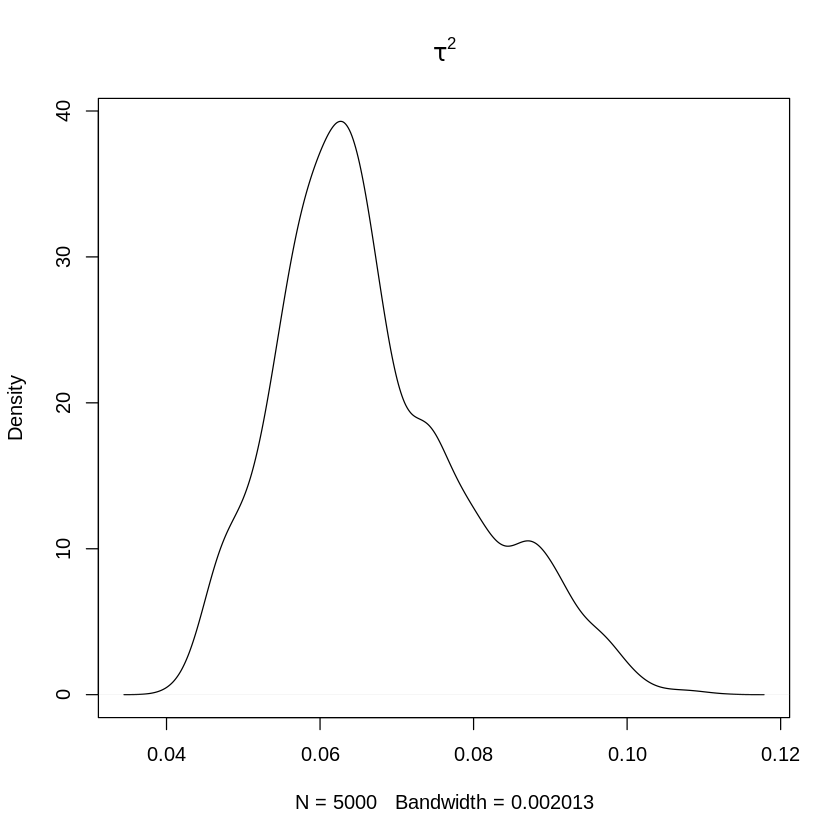

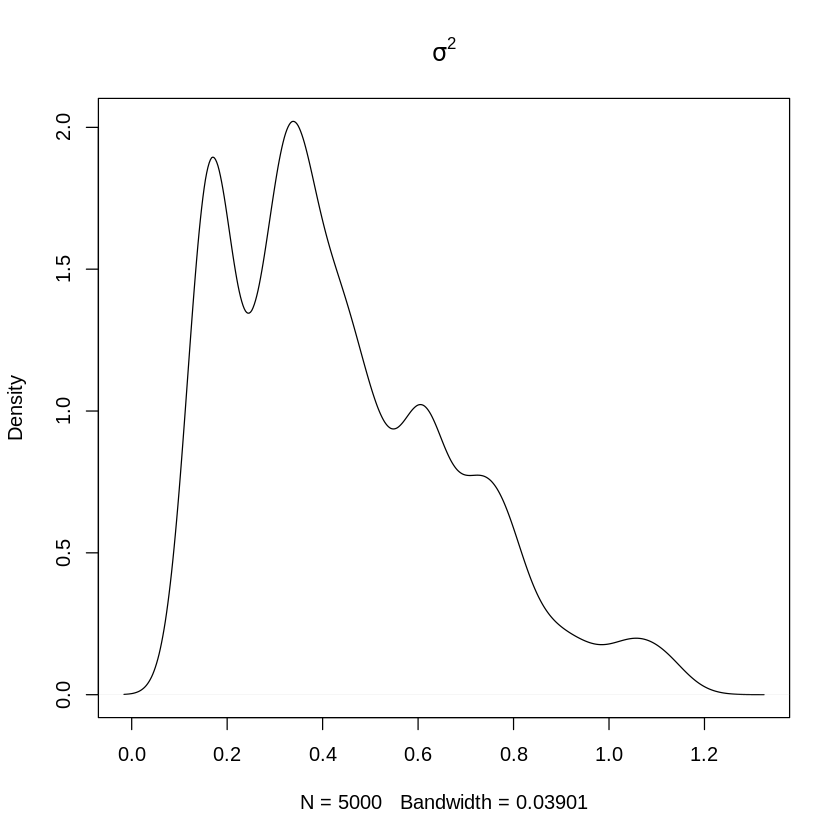

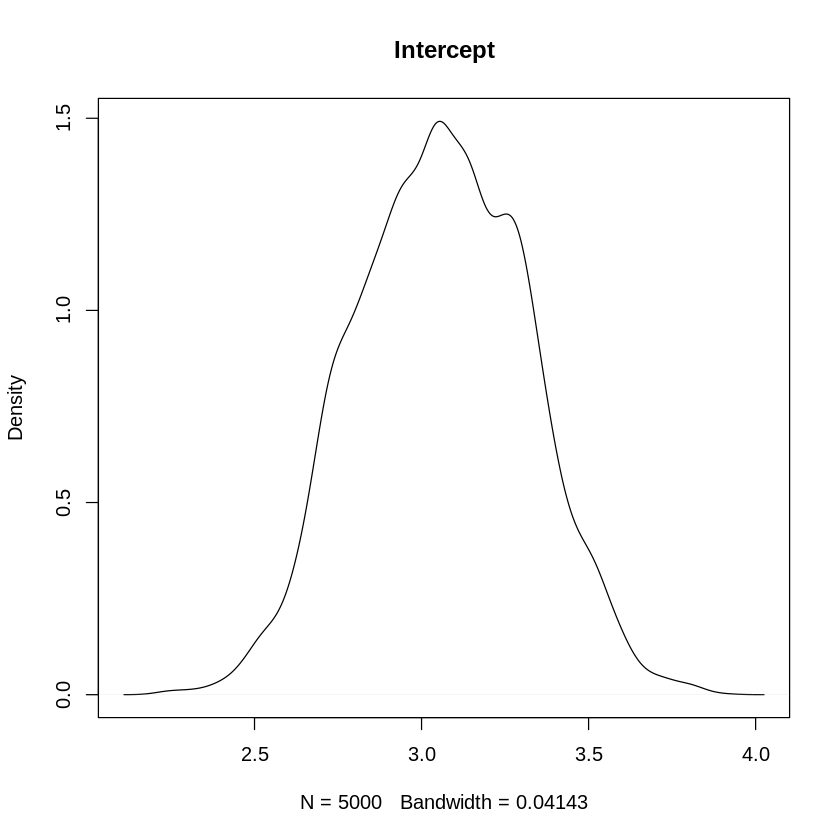

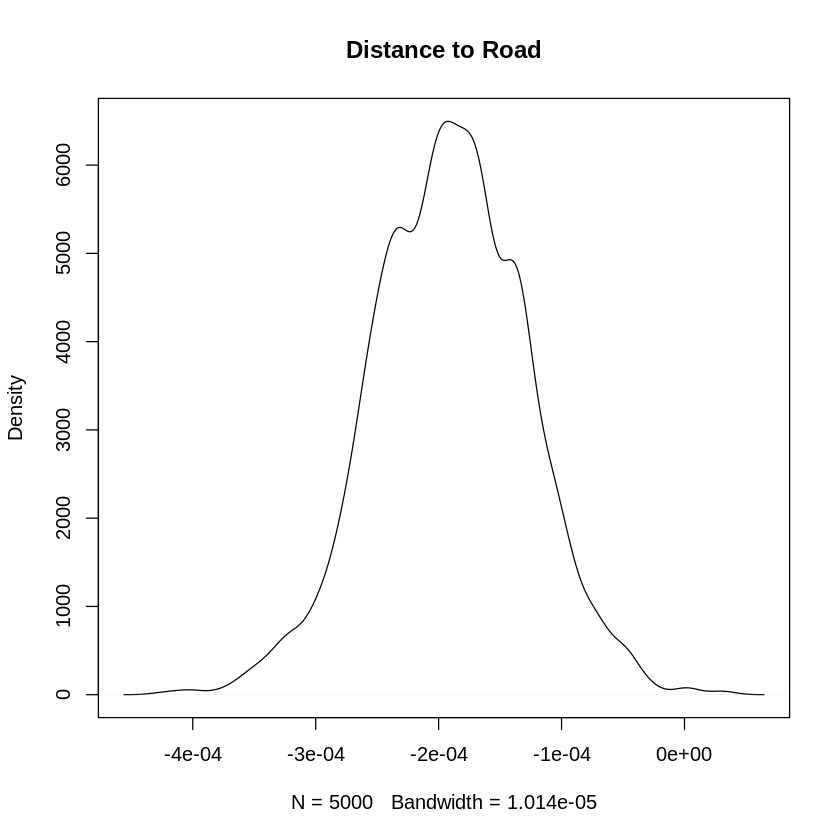

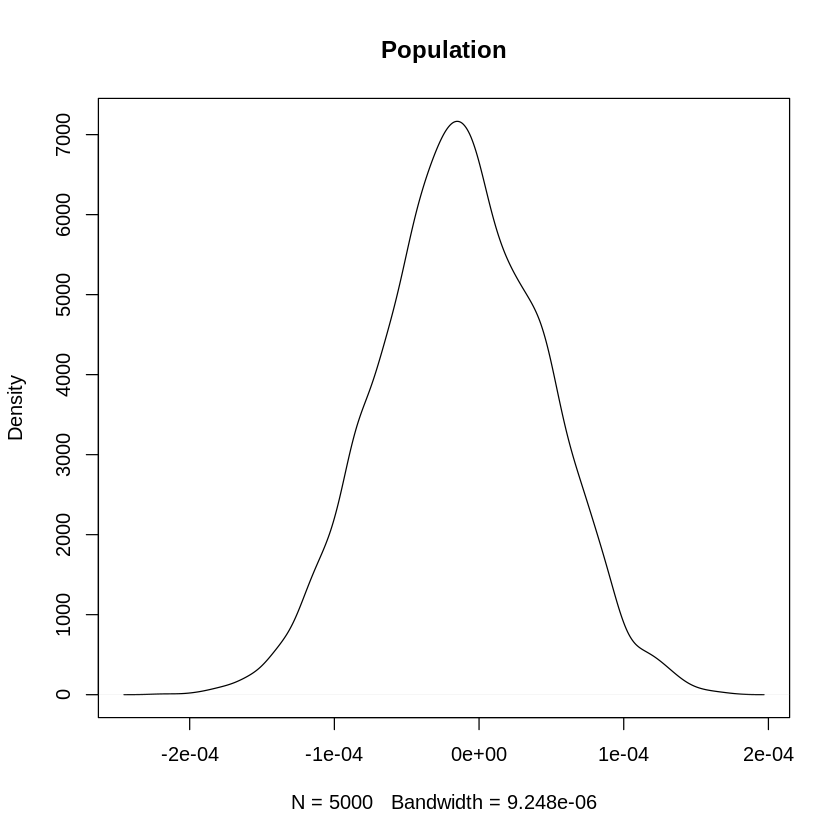

In [253]:
dtau = density(model.presence$samples$tau2)
dsigma = density(model.presence$samples$sigma2)

plot(dtau,main=expression(tau^2))
plot(dsigma,main=expression(sigma^2))
plot(beta1,main="Intercept")
plot(beta2,main="Distance to Road")
plot(beta3,main="Population")

In [202]:
mod_sig = glm(formula, data=TDF, family=binomial())
#mod1.summary()

In [203]:
summary(mod_sig)


Call:
glm(formula = formula, family = binomial(), data = TDF)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4668  -0.4331  -0.4152  -0.3961   2.3224  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.339e+00  1.434e-01 -16.317   <2e-16 ***
Disttoroadm -9.027e-05  5.469e-05  -1.651   0.0988 .  
Populationm  4.470e-05  4.833e-05   0.925   0.3550    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2342.0  on 4060  degrees of freedom
Residual deviance: 2338.4  on 4058  degrees of freedom
AIC: 2344.4

Number of Fisher Scoring iterations: 5


In [204]:
confint(mod_sig)

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-2.624556e+00,-2.062391e+00
Disttoroadm,-1.979250e-04,1.659753e-05
Populationm,-4.997744e-05,1.395857e-04


## Instantiate Geospatial data

In [13]:
library(lattice)
library(sp)


In [14]:
coordinates(TDF) <- c("Longitude","Latitude")

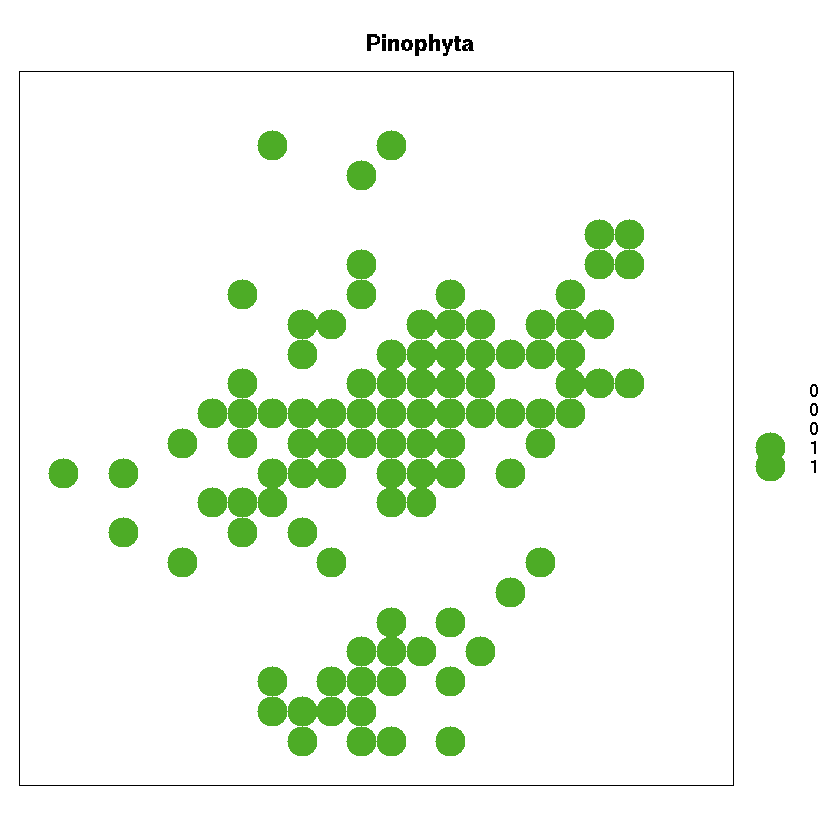

In [15]:
bubble(TDF,"Pinophyta")

## Spatial analysis in R
First, exploratory

In [29]:
library(gstat)

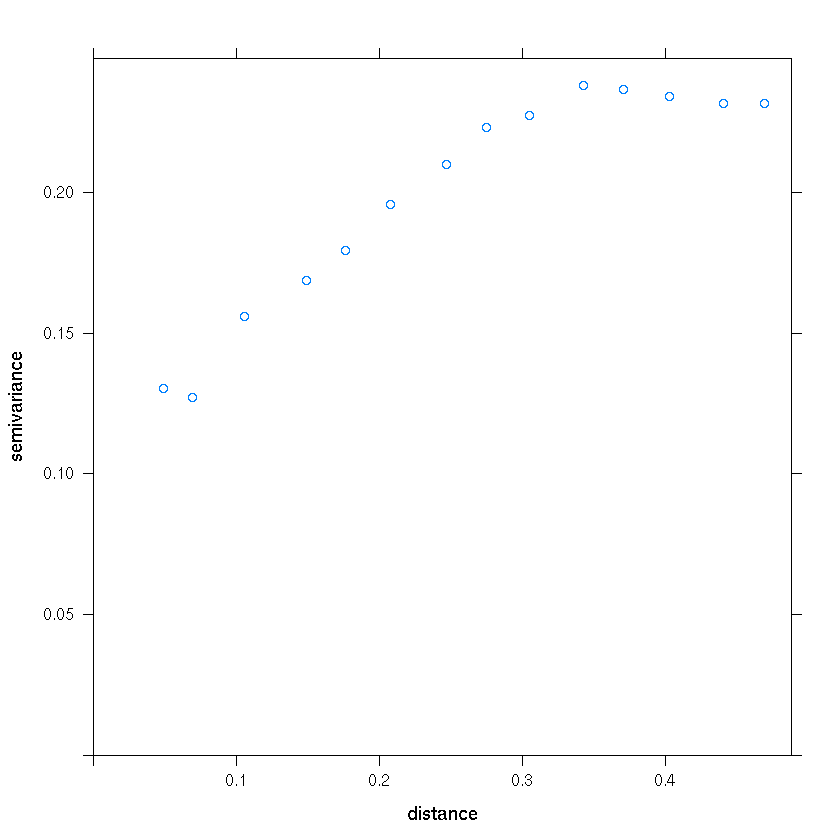

In [39]:
plot(variogram(Pinophyta ~ 1,TDF))

In [40]:
install.packages("geoR")

Warning message in install.packages("geoR"):
“installation of package ‘geoR’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [41]:
install.packages("geoRglm")

also installing the dependency ‘geoR’

Warning message in install.packages("geoRglm"):
“installation of package ‘geoR’ had non-zero exit status”Warning message in install.packages("geoRglm"):
“installation of package ‘geoRglm’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [46]:
library('spdep')

Loading required package: Matrix
Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


In [47]:
model_car = spautolm(Pinophyta ~ Dist.to.road_m +  Population_m + tipos,data=TDF,family="CAR")

ERROR: Error in inherits(listw, "listw"): argument "listw" is missing, with no default
